In [730]:
import pandas as pd
import requests
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer,RobustScaler
%matplotlib inline
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import  GradientBoostingRegressor,GradientBoostingClassifier,AdaBoostRegressor,BaggingRegressor,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error ,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR,SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score ,confusion_matrix
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures


### Train Dataset

In [768]:
flag=False
train_dataset=pd.read_csv('INPUT/diamonds_train.csv',index_col=0)
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [750]:
train_dataset.shape

(40345, 10)

### Test Dataset

In [769]:
test_dataset=pd.read_csv('INPUT/diamonds_test.csv',index_col=0)


In [752]:
test_dataset.shape

(13449, 9)

# 1.Encoding of the categorical columns

I tried also the 'get dummies approach', but the label encoding performed better.

In [770]:
cat_col=['cut', 'color', 'clarity']
train_dataset[cat_col]=train_dataset[cat_col].apply(LabelEncoder().fit_transform)
train_dataset.dtypes
train_dataset[cat_col]=train_dataset[cat_col]+1

In [771]:
test_dataset[cat_col]=test_dataset[cat_col].apply(LabelEncoder().fit_transform)
test_dataset[cat_col]=test_dataset[cat_col]+1


# 2. removing of 0-values and outliars

In [772]:
#0 values of x and y columns
train_dataset.loc[(train_dataset['x']==0) | (train_dataset['y']==0)]
train_dataset=train_dataset.loc[(train_dataset['x']>0) | (train_dataset['y']>0)]
train_dataset.loc[18027,'x']=train_dataset['x'].median()
train_dataset.loc[18027,'z']=train_dataset['z'].median()
train_dataset.loc[(train_dataset['z']==0)]

#guessing of the missing z-values with an Elastic Net model
cols=['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',]
m=ElasticNet()
train_dataset_X=train_dataset.loc[0:10000,cols]
train_dataset_y=train_dataset.loc[0:10000,'z']
m.fit(train_dataset_X, train_dataset_y)
test_dataset1=train_dataset.loc[(train_dataset['z']==0),cols]                                 
y_pred=m.predict(test_dataset1)
train_dataset.loc[train_dataset['z']==0,'z']=y_pred
train_dataset.loc[(train_dataset['z']==0)]
#removing of outliars of 'y' and 'z' columns
train_dataset=train_dataset.loc[~(train_dataset['y']>30)|(train_dataset['z']>30)]


# 3. Price and categorical features Transformation

In [773]:
#applying log transformation to make the relation carat-price more linear
flag=True
train_dataset['logprice']=np.log(train_dataset['price'])
train_dataset['price']=train_dataset['logprice']
train_dataset.drop('logprice',axis=1,inplace=True)

'''def trasf(x):
    return x**(1/3)
train_dataset['carat']=train_dataset['carat'].apply(trasf)
test_dataset['carat']=test_dataset['carat'].apply(trasf)
'''
#applying a weight to the categorical features
train_dataset['cut/wt']=train_dataset['cut']/train_dataset['carat']
train_dataset['color/wt']=train_dataset['color']/train_dataset['carat']
train_dataset['clarity/wt']=train_dataset['clarity']/train_dataset['carat']
train_dataset = train_dataset.drop(['cut','color','clarity'], axis=1)

test_dataset['cut/wt']=test_dataset['cut']/test_dataset['carat']
test_dataset['color/wt']=test_dataset['color']/test_dataset['carat']
test_dataset['clarity/wt']=test_dataset['clarity']/test_dataset['carat']
test_dataset = test_dataset.drop(['cut','color','clarity'], axis=1)


# 4. New flag column 'category' to highlight the outliers

I would like to divide my database in 2 or 3 different databasees, in order to create a more precise model for the different price ranges:
Database1 (Normal datapoints): 0<carat<q_h2
Database2 (Normal datapoints): q_h2<carat<q_h1
Database3 (Normal datapoints): q_h1<carat<end
Since the 2 model solution performed better I split the database in just 2 new databases.

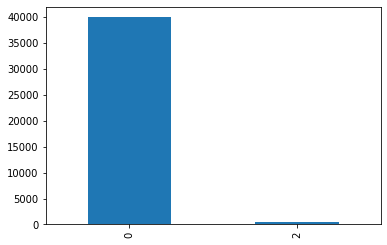

In [774]:

q_hi  = train_dataset["carat"].quantile(1)
q_h2  = train_dataset["carat"].quantile(0.99)

def fillcat(x):
    if (x > q_h2)and(x<q_hi):
        return 2
    elif (x>q_hi):
        return 1
    else:
        return 0
    
#new column to assign each point to a database    
train_dataset['category']=train_dataset['carat'].apply(fillcat)

train_dataset['category'].value_counts().plot.bar()


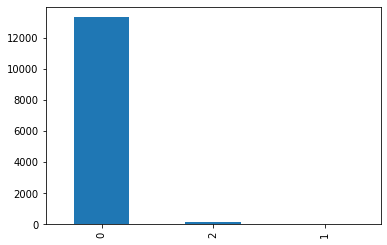

In [775]:
#same operation for the test dataset
test_dataset['category']=test_dataset['carat'].apply(fillcat)
test_dataset['category'].value_counts().plot.bar()

# 5.Prediction of the category column for the test_dataset 

In the final solution I did not include this passage. 
At the beginning I tried to make the division of the databases based on price, and I guessed the category of the test set points based on the other columns using a Random Forest classifier and other models. It did not perform better than my best solution.

In [460]:
'''#Accuracy test
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z']#, 'cut/wt', 'color/wt',
      #'clarity/wt']
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z']#, 'cut', 'color',
      #     'clarity']

train_dataset_X=train_dataset[cols]
train_dataset_y=train_dataset['category']

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X, train_dataset_y, test_size = 0.2, random_state = 0)
models = {
    "GradientBoostingClassifier" : GradientBoostingClassifier(),
    "GradientBoostingClassifierP" : GradientBoostingClassifier(n_estimators=500, learning_rate=0.3),
    "RandomForestClassifier" : RandomForestClassifier(n_estimators=100),
    "Logistic" : LogisticRegression(),
    "SuperVectorC" : SVC()
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train1, y_train1)
    y_pred=model.predict(X_test1)
    print(modelName,accuracy_score(y_test1, y_pred))
    print(confusion_matrix(y_test1, y_pred, normalize='true'))
#m =RandomForestClassifier(bootstrap=True,max_depth=70,
                        #    max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)

#m.fit(X_train1, y_train1)
#print("Training complete")
#y_pred=m.predict(X_test1)
#accuracy_score(y_test1, y_pred)

Training model: GradientBoostingClassifier
GradientBoostingClassifier 0.979300941993059
[[0.99657925 0.00342075]
 [0.8        0.2       ]]
Training model: GradientBoostingClassifierP
GradientBoostingClassifierP 0.9768220128904314
[[0.99125808 0.00874192]
 [0.67428571 0.32571429]]
Training model: RandomForestClassifier
RandomForestClassifier 0.979300941993059
[[0.99341188 0.00658812]
 [0.65714286 0.34285714]]
Training model: Logistic


/Users/silviaserafini/Library/Python/3.6/lib/python/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic 0.9797967278135845
[[0.9953123 0.0046877]
 [0.72      0.28     ]]
Training model: SuperVectorC
SuperVectorC 0.9783093703520079
[[1. 0.]
 [1. 0.]]


'm =RandomForestClassifier(bootstrap=True,max_depth=70,\n                            max_features=\'auto\',min_samples_leaf=2,min_samples_split=2,n_estimators=700)\n\nm.fit(X_train1, y_train1)\nprint("Training complete")\ny_pred=m.predict(X_test1)\naccuracy_score(y_test1, y_pred)'

In [449]:
confusion_matrix(y_test1, y_pred, normalize='true')

array([[0.99569239, 0.00430761],
       [0.41142857, 0.58857143]])

In [472]:
'''if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
       'clarity/wt'
       ]
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity'
           ]

train_dataset_X=train_dataset[cols]
train_dataset_y=train_dataset['category']
 
m =RandomForestClassifier(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
    
m.fit(train_dataset_X, train_dataset_y)
print("Training complete")
y_pred=m.predict(test_dataset[cols])
test_dataset['category']=y_pred'''

Training complete


# 6. training of the 2 models 

I trie also the 3-models approach, but did not perform better than the 2 models approach.

In [776]:
#first model for outliars 0.99-1
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
           'clarity/wt']
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity']
       
train_dataset_X1=train_dataset[train_dataset.category ==2][cols]
train_dataset_y1=train_dataset[train_dataset.category ==2]['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X1, train_dataset_y1, test_size = 0.1, random_state = 0)
m2 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)

m2.fit(X_train1, y_train1)

print("Training complete")
if flag:
    y_test2=np.exp(y_test1)
    y_pred1=m2.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))
else:
    y_test2=np.exp(y_test1)
    y_pred1=m2.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))

Training complete
1899.7648468875086


In [ ]:
#not included on the final solution
'''#second model for outliars 0.98-1
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
           'clarity/wt']
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity']
       
train_dataset_X1=train_dataset[train_dataset.category ==1][cols]
train_dataset_y1=train_dataset[train_dataset.category ==1]['price']

X_train1, X_test1, y_train1, y_test1 = train_test_split(train_dataset_X1, train_dataset_y1, test_size = 0.1, random_state = 0)
m1 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
    

m1.fit(X_train1, y_train1)
print("Training complete")
'''


In [686]:
if flag:
    y_test2=np.exp(y_test1)
    y_pred1=m1.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))
else:
    y_test2=np.exp(y_test1)
    y_pred1=m1.predict(X_test1)
    y_pred2=np.exp(y_pred1)
    print(mean_squared_error(y_test2, y_pred2,squared=False))

2022.1808154195353


In [344]:
#this was a test to see how the model trained with the 'normal points' performed in the outlairs prediction.
'''prova da eliminare
m0 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
train_dataset_X0=train_dataset[cols]
train_dataset_y0=train_dataset['price']

X_train0, X_test0, y_train0, y_test0 = train_test_split(train_dataset_X0, train_dataset_y0, test_size = 0.2, random_state = 0)
m0.fit(X_train0, y_train0)  
y_test2=np.exp(y_test0)
y_predout=m0.predict(X_test0)
y_pred2=np.exp(y_predout)
print(mean_squared_error(y_test2, y_pred2,squared=False))
 
y_test2=np.exp(y_test1)
y_predout=m0.predict(X_test1)
y_pred2=np.exp(y_predout)
print(mean_squared_error(y_test2, y_pred2,squared=False))'''

563.1688840090344


In [777]:
#third model, for normal values (0->0.99)
if flag:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut/wt', 'color/wt',
           'clarity/wt'
           ]
else:
    cols=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color',
           'clarity'
           ]
train_dataset_X0=train_dataset[train_dataset.category ==0][cols]
train_dataset_y0=train_dataset[train_dataset.category ==0]['price']

X_train0, X_test0, y_train0, y_test0 = train_test_split(train_dataset_X0, train_dataset_y0, test_size = 0.2, random_state = 0)
m0 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
    
m0.fit(X_train0, y_train0)
print("Training complete")

Training complete


In [778]:
if flag:
    y_test3=np.exp(y_test0)
    y_pred0=m0.predict(X_test0)
    y_pred3=np.exp(y_pred0)
    print(mean_squared_error(y_test3, y_pred3,squared=False))
else:
    y_test3=np.exp(y_test0)
    y_pred0=m0.predict(X_test0)
    y_pred3=np.exp(y_pred0)
    print(mean_squared_error(y_test3, y_pred3,squared=False))

520.1713827720228


In [779]:
#guess of the weighted RMSE of the ensambled model. Maybe it is not the best way to predict it.
520*0.99+1899*0.01

533.79

# 7. Final Prediction

I trained the models with the test_dataset.

In [780]:
m2==RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
  
'''m1==RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)
 '''   
m0 =RandomForestRegressor(bootstrap=True,max_depth=70,
                            max_features='auto',min_samples_leaf=2,min_samples_split=2,n_estimators=700)

#filters for the test database with the labels of the column that I created
'''outliers=train_dataset.category ==1'''
outliers2=train_dataset.category ==2
normal=train_dataset.category ==0

#creation of the databases
train_dataset0= train_dataset[normal]
'''train_dataset1= train_dataset[outliers]'''
train_dataset2= train_dataset[outliers2]

#fitting of the 2 models: m0:normal points, m2: outliars (top1% of carat)
m0.fit(train_dataset0[cols], train_dataset0['price'])
'''m1.fit(train_dataset1[cols], train_dataset1['price'])'''
m2.fit(train_dataset2[cols], train_dataset2['price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [781]:
#prediction of the models
'''y_predoutliers=m1.predict(test_dataset[cols])'''
y_prednormal=m0.predict(test_dataset[cols])
y_intermediate=m2.predict(test_dataset[cols])

#filters
'''usefirstmodel=test_dataset['category']==1'''
usesecondmodel=test_dataset['category']==2

#merging of the predictions of the 2 models.
y_pred=y_prednormal
'''y_pred[usefirstmodel]=y_predoutliers[usefirstmodel]'''
y_pred[usesecondmodel]=y_intermediate[usesecondmodel]
                              


# 8. Saving of the results

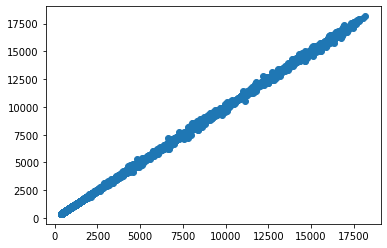

In [915]:
#I plotted the current solution vs my best solution to check the differencies
fil=pd.read_csv('submissionDoubleModelCarat98.csv')
y_pred2=np.exp(y_pred)
fil.shape
plt.scatter(tentative,fil['price'])

In [784]:
#preparation of the answer
df=pd.DataFrame(y_pred2)
df=df.reset_index()
df.columns=('Id','price')
df[['Id', 'price']].to_csv('submissionDouble533Model99.csv',index=False)

# 9. Final  tentative to combine my 2 best scored solutions

In [914]:
submission1=pd.read_csv('submissionDoubleModelCarat98.csv')
doublemodel=pd.read_csv('submissionAutoML.csv')

tentative=(submission1['price']+doublemodel['price'])/2

#If the difference of the 2 solution is higher than 1200, I replace the value with the most secure solution
diff=(submission1['price']-doublemodel['price'])

filter1=(diff>1200) | (diff <-1200)
filter1.value_counts()
tentative[filter1]=submission1['price'][filter1]
filter1.value_counts()


False    13426
True        23
Name: price, dtype: int64

In [917]:
#submission of the Hybrid solution
doublemodel['price']=tentative
doublemodel[['Id', 'price']].to_csv('submissionHybridHope1.csv',index=False)